In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime, timedelta

from IPython.display import clear_output

Pipeline:

Raw Data -> Preprocess Raw Data (Remove Seasonality) -> Train Predictor (On Stationary Data) -> Predict Auto Regressively -> Transform Predictions (Add Seasonality) -> Present

In [2]:
raw_data = pd.read_csv("1989 to 2023 CombinedData.csv")

In [3]:
def plotSeasonality(df, col):
    fig, ax = plt.subplots(2, 3, figsize = (24, 14))

    df.boxplot(column = [col], by = "Month", ax = ax[0, 0])
    ax[0, 1].scatter(df["Month"], df[col])
    ax[0, 2].plot(df.groupby(by = "Month").mean(numeric_only = True)[col].values)
    
    
    df.boxplot(column = [col], by = "Year", ax = ax[1, 0])
    ax[1, 1].scatter(df["Year"], df[col])
    ax[1, 2].plot(df.groupby(by = "Year").mean(numeric_only = True)[col].values)
    
    ax[0, 0].set_title("Month - Box Plot")
    ax[0, 1].set_title("Month - Scatter Plot")
    ax[0, 2].set_title("Month - Average")
    ax[1, 0].set_title("Year - Box Plot")
    ax[1, 1].set_title("Year - Scatter Plot")
    ax[1, 2].set_title("Year - Average")
    
    plt.show()
    

# Check Monthly Seasonality

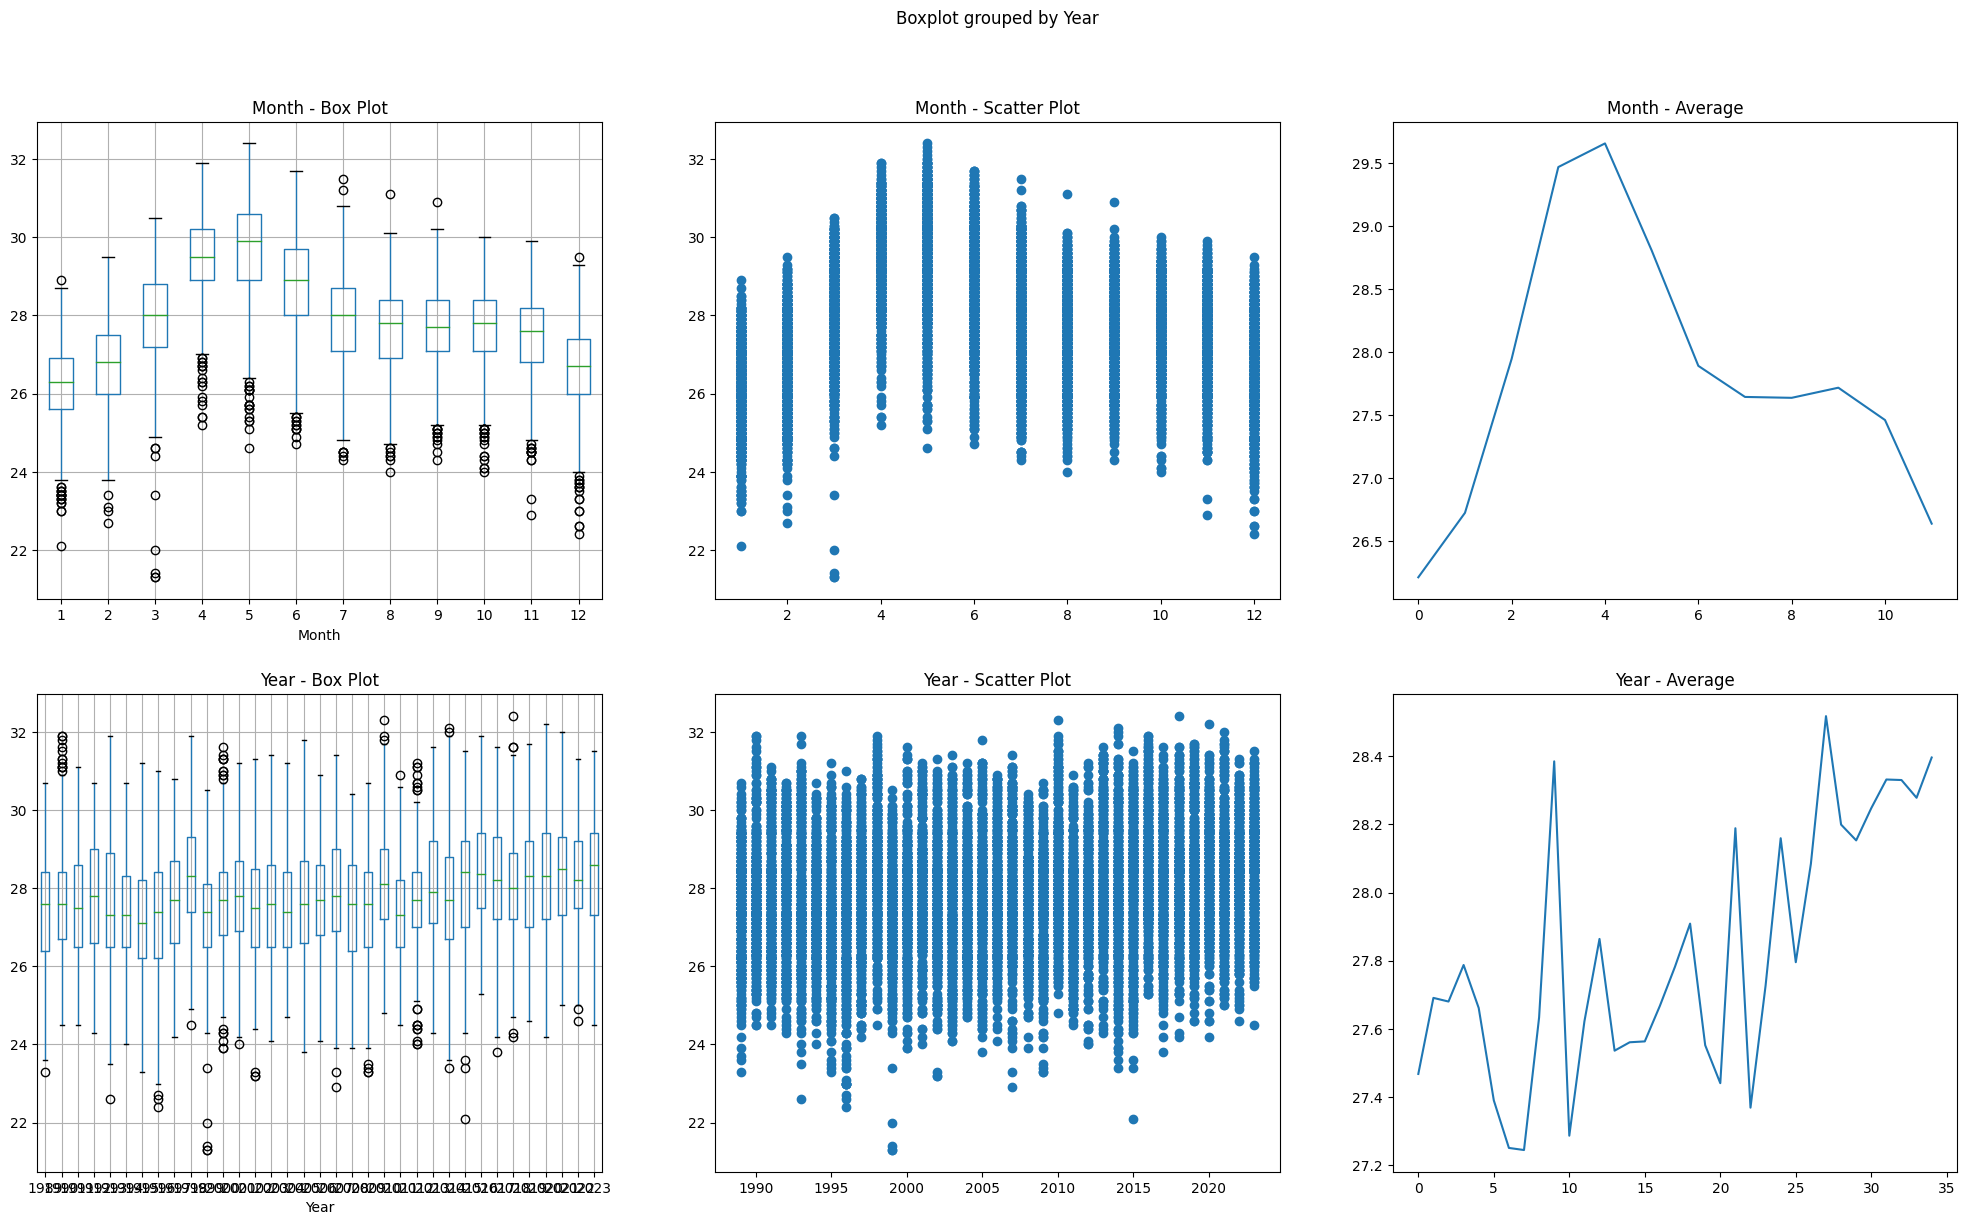

In [4]:
df = raw_data.copy()
df["Month"] = pd.DatetimeIndex(df["datetime"]).month
df["Year"] = pd.DatetimeIndex(df["datetime"]).year

plotSeasonality(df, "temp")


# Remove Yearly Mean

In [5]:
MODEL_YEARLY_STD = None 
MODEL_YEARLY_STD_SCALE = 0
YEARLY_SEASONALITY_LENGTH = 7

normalized_yearly_df = df.copy()
normalized_yearly_df["TempMod"] = normalized_yearly_df["temp"]

years = pd.DatetimeIndex(normalized_yearly_df["datetime"]).year.unique().to_list()
min_val = years[0]
years_normalized = [(x - min_val) % YEARLY_SEASONALITY_LENGTH for x in years]
normalized_yearly_df["YearAug"] = (pd.DatetimeIndex(normalized_yearly_df["datetime"]).year - min_val) % YEARLY_SEASONALITY_LENGTH

yr_grp = normalized_yearly_df.groupby(by = "YearAug").mean(numeric_only = True)["temp"]

for year in normalized_yearly_df["YearAug"].unique():
    normalized_yearly_df.loc[normalized_yearly_df["YearAug"] == year, "TempMod"] -= yr_grp[year]

yearly_mean = normalized_yearly_df["TempMod"].mean()
normalized_yearly_df["TempMod"] = normalized_yearly_df["TempMod"] - yearly_mean

MODEL_YEARLY_STD = np.std(normalized_yearly_df["TempMod"])

# Remove Monthly Mean

Since there is no seasonality (Or is there) found on the yearly data, but strong seasonality observed in Monthly Data

In [6]:
normalized_df = normalized_yearly_df.copy()
normalized_df["TempMod"] = normalized_df["TempMod"]

month_grp = normalized_df.groupby(by = "Month").mean(numeric_only = True)["TempMod"]

# For Every Month in the list of unique Months in the Dataframe
for month in normalized_df['Month'].unique():
    # Look for df["Month"] == current unique month, Change TempMod Value to be (currentTemp of the Day) - (Monthly Mean)
    normalized_df.loc[normalized_df['Month'] == month, 'TempMod'] -= month_grp[month]

# Get The Mean of the Normalized Month Groups
monthly_mean = normalized_df['TempMod'].mean()
print("Current Monthly Mean:", monthly_mean)

# Subtract the Normalized Temperature Mean by the Total Mean of all the other Normalized
normalized_df['TempMod'] = normalized_df['TempMod'] - monthly_mean
# current_monthly_mean = normalized_df["TempMod"].mean()




Current Monthly Mean: 3.557438401677729e-17


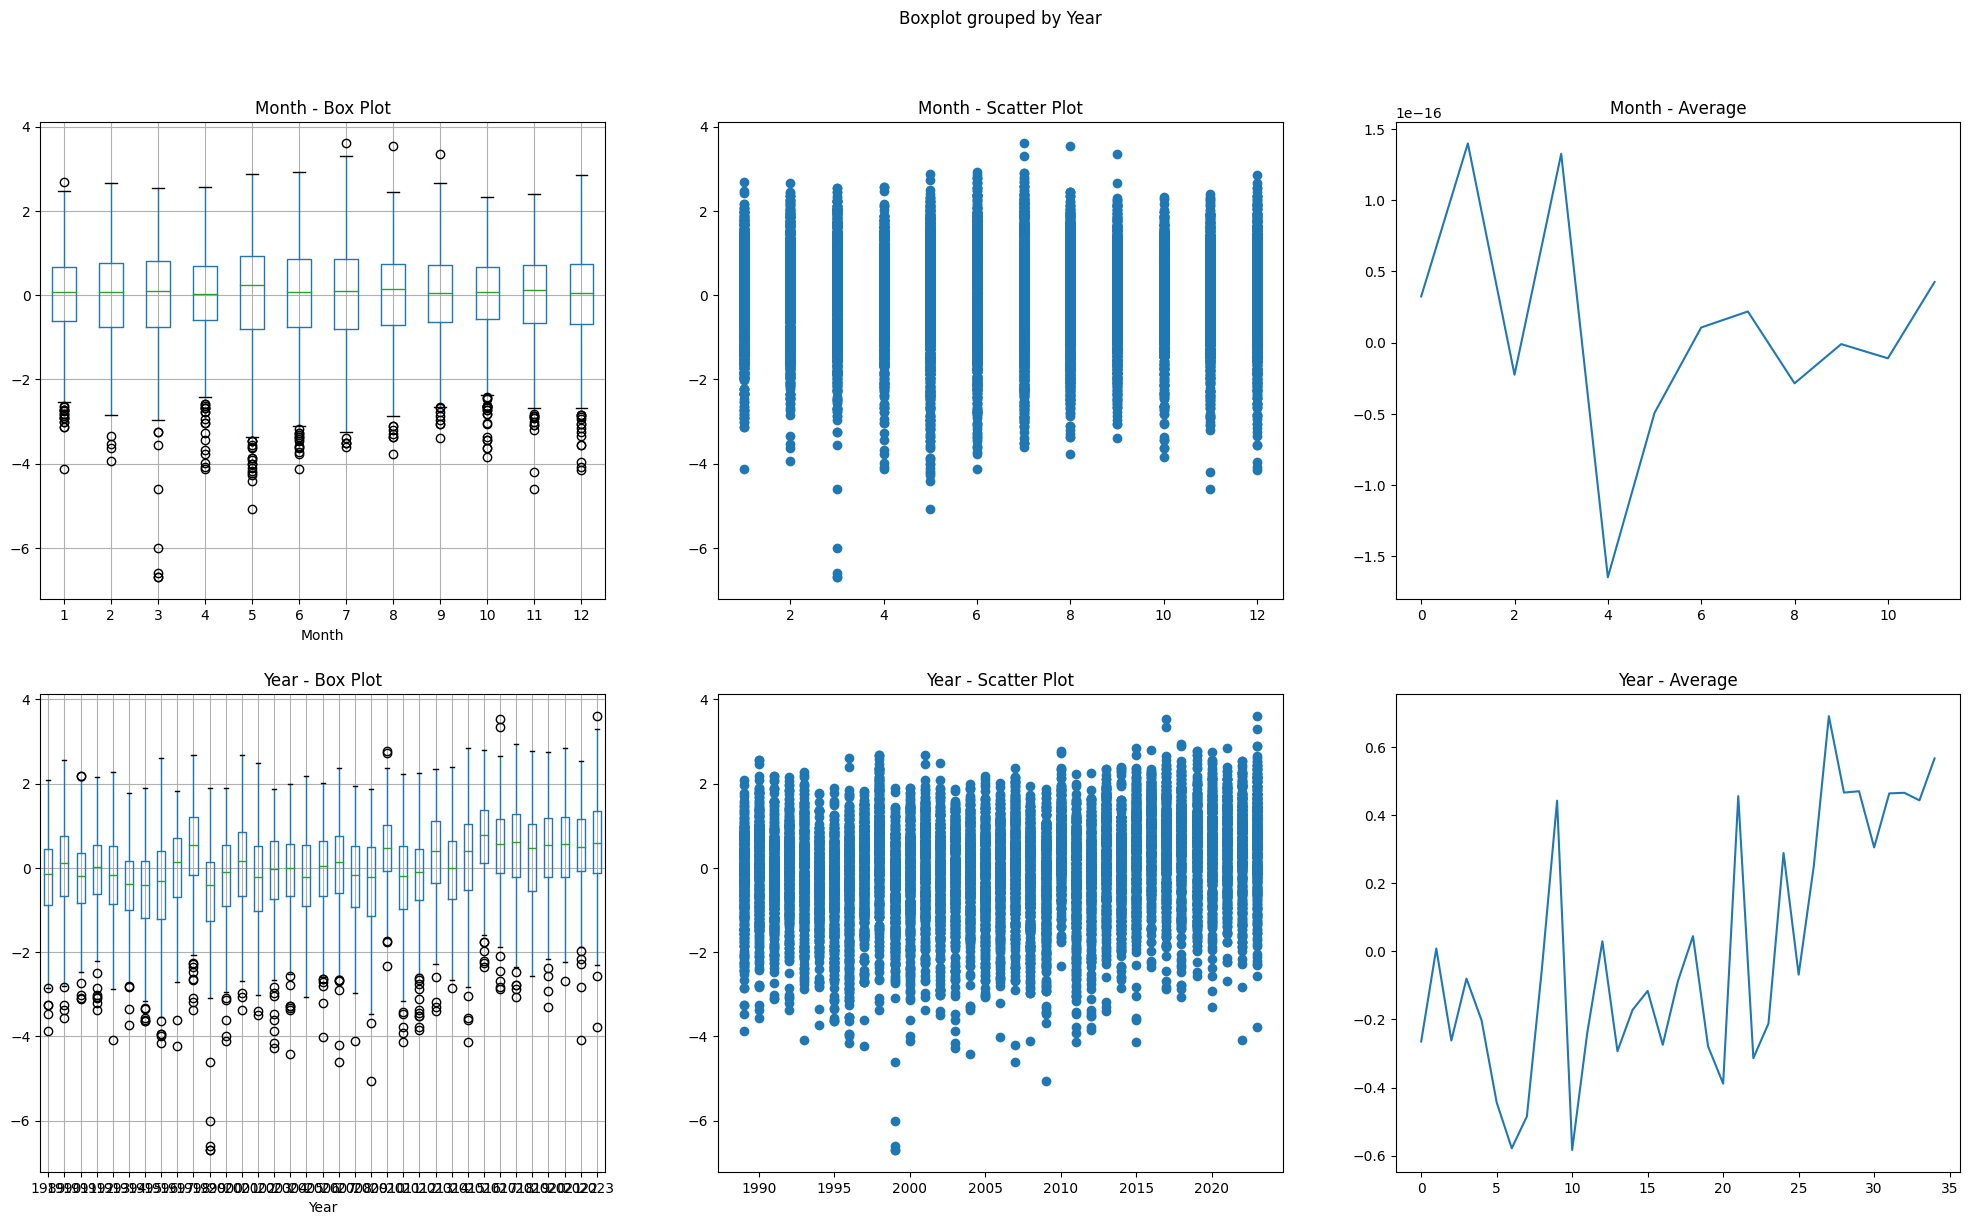

In [7]:
plotSeasonality(normalized_df, "TempMod")

In [8]:
MODEL_ORDER = 2
MODEL_PREDICTOR = LinearRegression()
MODEL_SIGMA = None 
MODEL_STD_SCALE = 0.8

In [9]:
def window_data(data):
    n = len(data)
    x = []
    y = []
    for i in range(n - MODEL_ORDER):
        x.append(data[i : i + MODEL_ORDER])
        y.append(data[i + MODEL_ORDER])
    
    return np.array(x), np.array(y)

In [10]:
train_data = normalized_df["TempMod"].to_numpy()
n = len(train_data)
split_point = int(0.7 * n)

MODEL_SIGMA = np.std(train_data[:split_point])
window_x, window_y = window_data(train_data)

train_x = window_x[:split_point]
test_x = window_x[split_point:]
train_y = window_y[:split_point]
test_y = window_y[split_point:]

In [11]:
MODEL_PREDICTOR.fit(train_x, train_y)

LinearRegression()

In [12]:
TARGET_YEAR = 2050
TARGET_MONTH = 12
TARGET_DATE = 31

target_datetime = datetime(TARGET_YEAR, TARGET_MONTH, TARGET_DATE)

StringFormat = "%Y-%M-%d"
raw_start_date = normalized_df["datetime"][MODEL_ORDER]
train_start_date = datetime.strptime(raw_start_date, StringFormat)
train_end_date = train_start_date + timedelta(days = len(train_y)) # + 1 Since Range

prediction_start_date = train_end_date # -1 + 1
prediction_end_date = datetime(TARGET_YEAR, TARGET_MONTH, TARGET_DATE) + timedelta(days = 1)

prediction_date_range = np.arange(prediction_start_date, prediction_end_date, timedelta(days = 1)).astype("datetime64[D]")
prediction_length = len(prediction_date_range)

# test_start_date = train_end_date + timedelta(days = 1)
# test_end_date = test_start_date + timedelta(days = len(preds)) # + 1 Since Range <

In [13]:
prediction_date_range[-1], prediction_date_range[0], train_end_date

(numpy.datetime64('2050-12-31'),
 numpy.datetime64('2013-07-04'),
 datetime.datetime(2013, 7, 4, 0, 1))

In [14]:
test_len = len(test_x)
preds = np.array([])

# This should have the values of the last X 
r_queue = np.copy(train_x)[-MODEL_ORDER]

# num_predictions = test_len
# num_predictions = 50 * 365
num_predictions = prediction_length

for i in tqdm(range(num_predictions)):

    # Reshape and do not apply on rolling queue 
    tr = np.reshape(r_queue, (1, -1))
    resid = np.random.normal(loc = 0, scale = MODEL_SIGMA * MODEL_STD_SCALE)
    year_resid = np.random.normal(loc = 0, scale = MODEL_YEARLY_STD * MODEL_YEARLY_STD_SCALE)

    # resid = 0
    next_val = MODEL_PREDICTOR.predict(tr) + resid + year_resid

    preds = np.append(preds, next_val)

    r_queue = np.roll(r_queue, -1)
    r_queue[-1] = next_val



100%|██████████| 13695/13695 [00:02<00:00, 6180.74it/s]


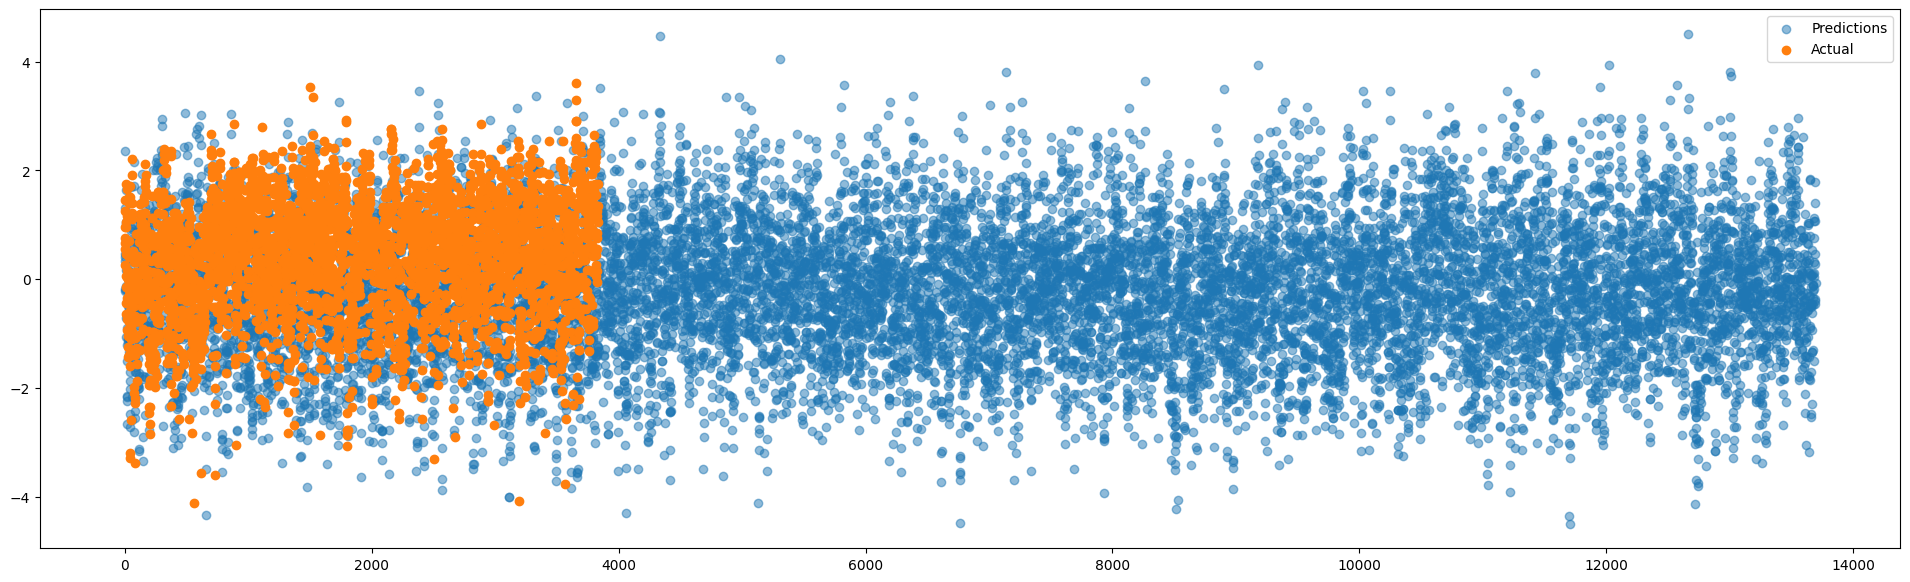

In [15]:
plt.figure(figsize=(24, 7))
plt.scatter(np.arange(0, len(preds)), preds, alpha = 0.5, label = "Predictions")
plt.scatter(np.arange(0, len(test_y)), test_y, label = "Actual")
plt.legend()
plt.show()

In [16]:
pred_df = normalized_df[["datetime", "TempMod"]]

In [17]:
StringFormat = "%Y-%M-%d"
raw_start_date = normalized_df["datetime"][MODEL_ORDER]
start_date = datetime.strptime(raw_start_date, StringFormat)
end_date = start_date + timedelta(days = len(train_y)) # + 1 Since Range <
test_start_date = end_date + timedelta(days = 1)
test_end_date = test_start_date + timedelta(days = len(preds)) # + 1 Since Range <

In [18]:
training_date_range = np.arange(start_date, end_date, timedelta(days = 1)).astype("datetime64[D]")
testing_date_range = np.arange(test_start_date, test_end_date, timedelta(days = 1)).astype("datetime64[D]")


In [19]:
full_datetime_range = np.concatenate((training_date_range, prediction_date_range))

In [20]:
concatenated_preds = np.concatenate((train_y, preds))

In [21]:
constructed_df = pd.DataFrame({
    "datetime" : full_datetime_range,
    "temp" : concatenated_preds
})

In [22]:
orig_vals = normalized_df[["datetime", "TempMod"]]["TempMod"][2:].values
cons_val = constructed_df["temp"].values[:len(orig_vals)]
diffs = np.absolute(orig_vals - cons_val)


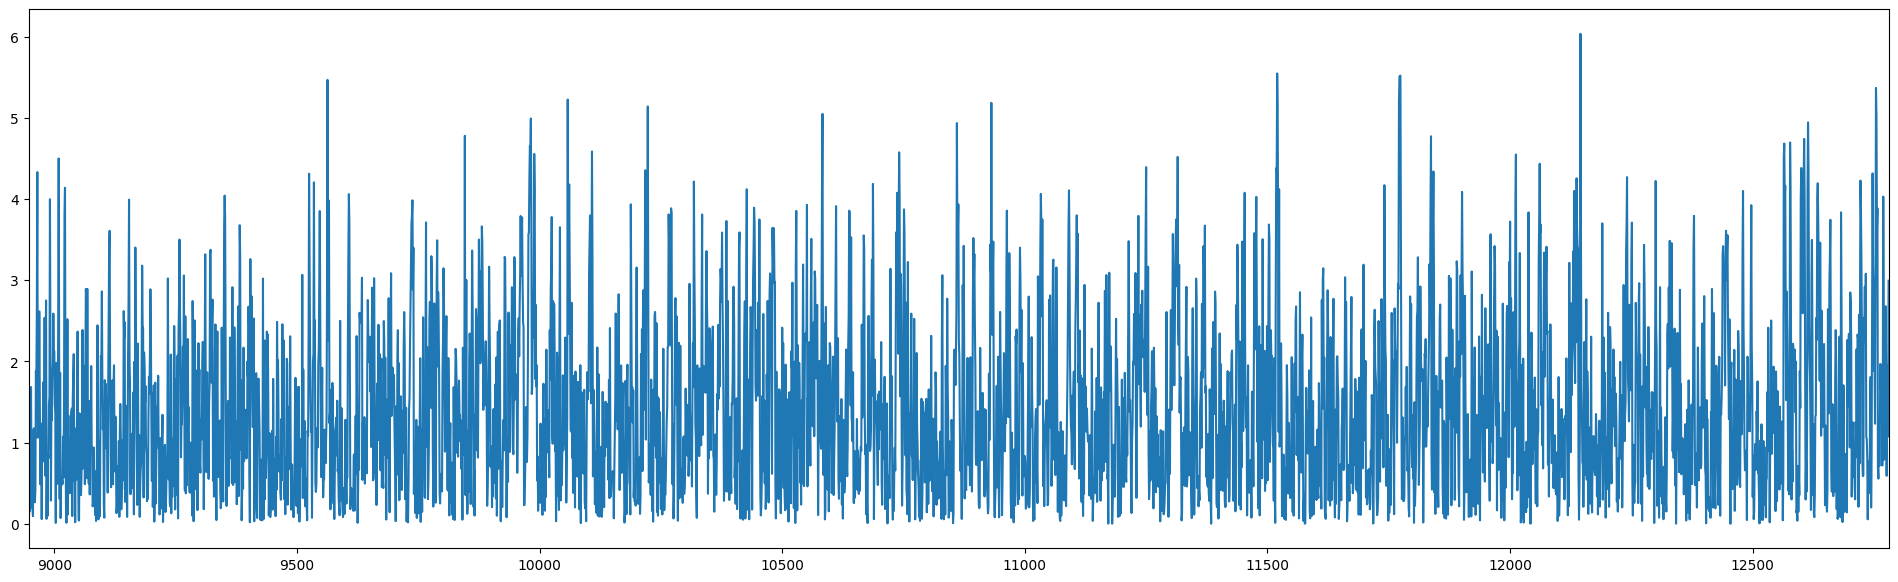

In [23]:
plt.figure(figsize=(24, 7))
plt.plot(diffs)
plt.xlim(len(cons_val) - len(test_y) - 1, len(cons_val) - 1)
plt.show()

In [24]:
# Reconstruct the Dates
# From Training X Add the dates
# Continue Dates until after Training X
# Add the Monthly Mean to Dataframe

In [25]:
constructed_df["Month"] = pd.DatetimeIndex(constructed_df["datetime"]).month
constructed_df["Year"] = pd.DatetimeIndex(constructed_df["datetime"]).year 


In [26]:
constructed_df["TempMod"] = constructed_df["temp"]

for month in constructed_df["Month"].unique():
    constructed_df.loc[constructed_df['Month'] == month, 'TempMod'] += month_grp[month]

constructed_df["TempMod"] += monthly_mean

In [27]:
constructed_df["YearAug"] = (pd.DatetimeIndex(constructed_df["datetime"]).year - min_val) % YEARLY_SEASONALITY_LENGTH

In [28]:
yr_grp

YearAug
0    27.731982
1    27.681928
2    27.941292
3    27.869677
4    27.863363
5    27.833516
6    27.828587
Name: temp, dtype: float64

In [29]:
for year in constructed_df["YearAug"].unique():
    constructed_df.loc[constructed_df['YearAug'] == year, 'TempMod'] += yr_grp[year]

<Axes: >

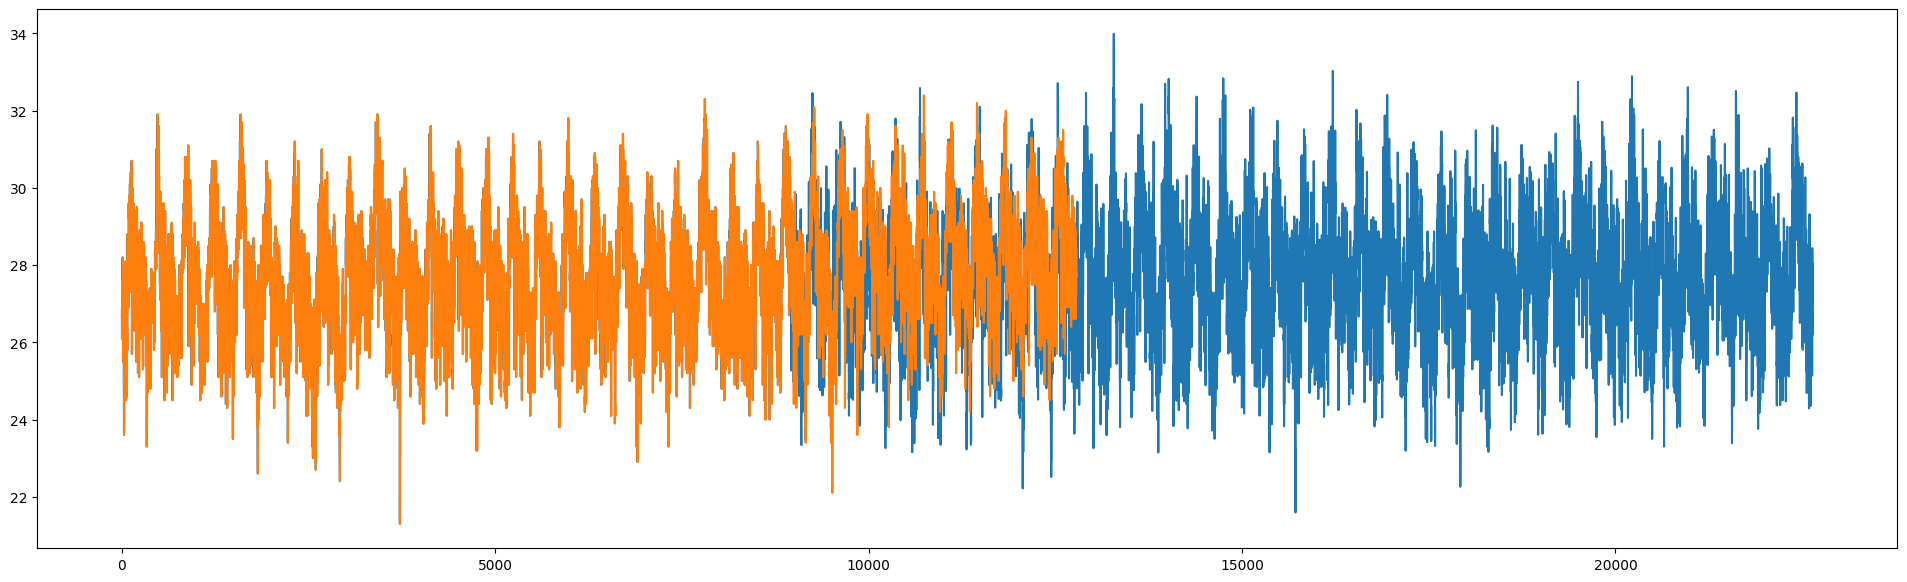

In [30]:
constructed_df["TempMod"].plot(figsize = (24, 7))
normalized_df["temp"].plot(figsize = (24, 7))

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
dec = constructed_df.copy()
# dec = df.copy()
dec.index = pd.DatetimeIndex(dec["datetime"])
dec["temp"] = dec["TempMod"]

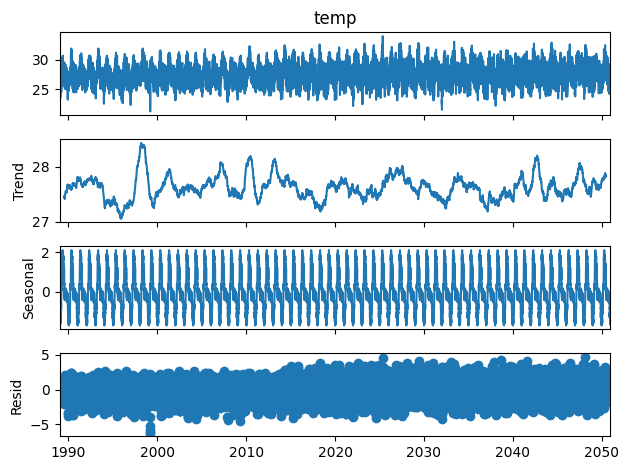

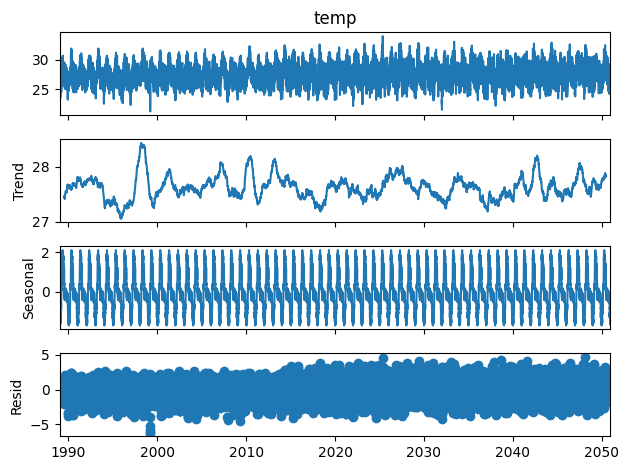

In [33]:

dec_result = seasonal_decompose(dec["temp"], model = "additive", period = 365)
# dec_result = seasonal_decompose(dec["temp"].copy(), model = "multiplicative")
dec_result.plot()


In [34]:
dec_result.observed

datetime
1989-01-03    26.700000
1989-01-04    26.100000
1989-01-05    26.200000
1989-01-06    26.100000
1989-01-07    27.100000
                ...    
2050-12-27    28.053060
2050-12-28    26.939387
2050-12-29    26.193114
2050-12-30    26.291554
2050-12-31    26.587564
Name: temp, Length: 22643, dtype: float64

<Axes: xlabel='datetime'>

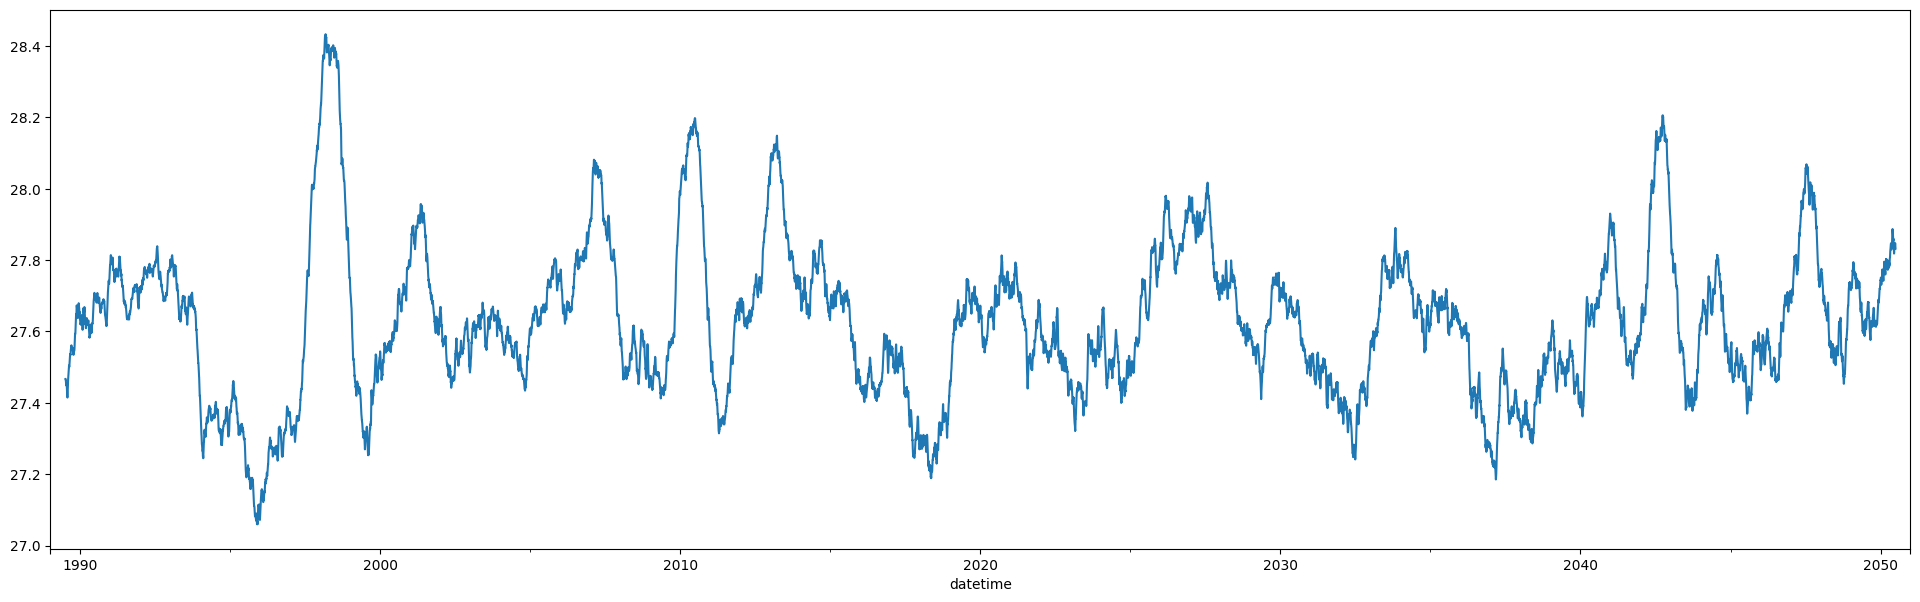

In [35]:
dec_result.trend.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

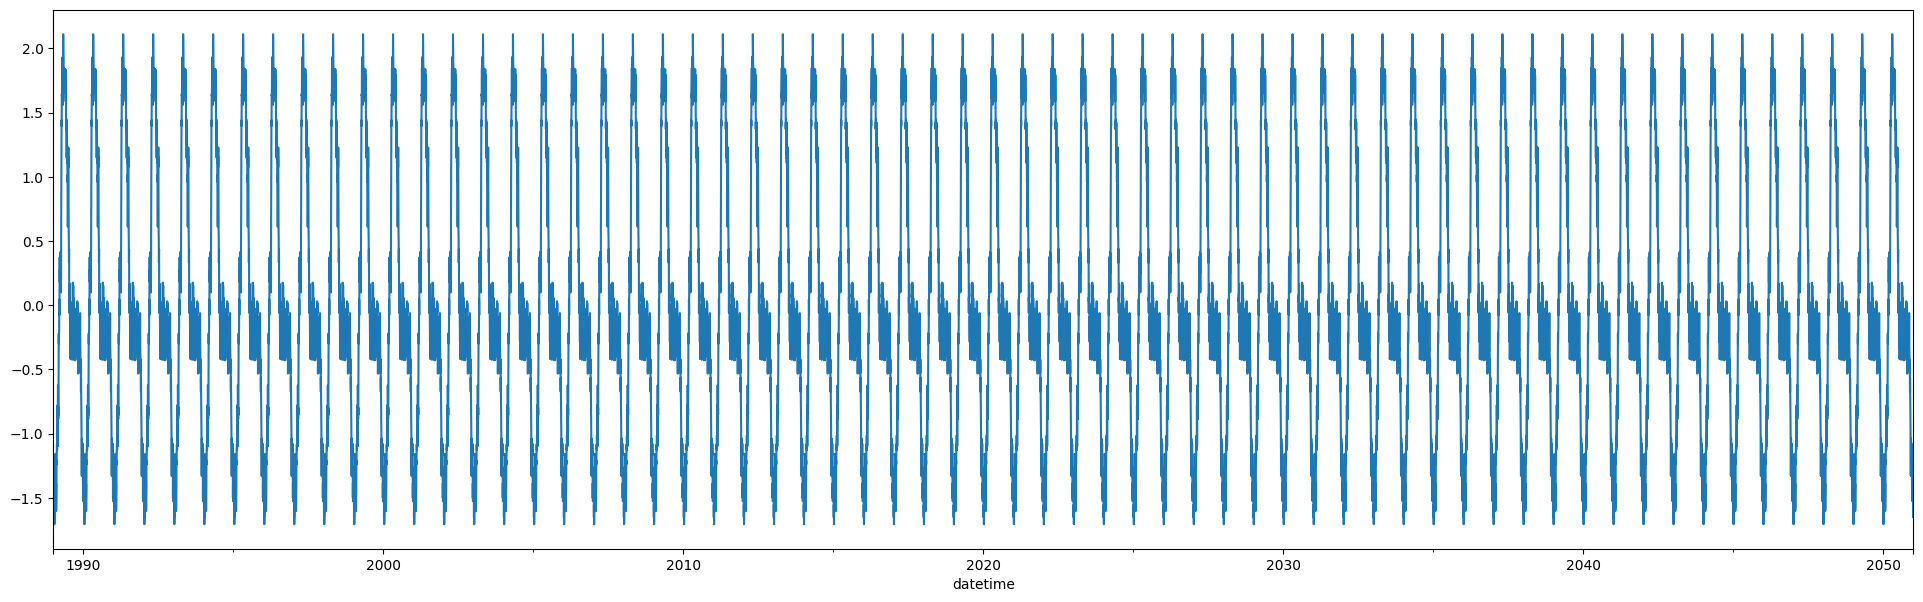

In [36]:
dec_result.seasonal.plot(figsize = (24, 7))

<Axes: xlabel='datetime'>

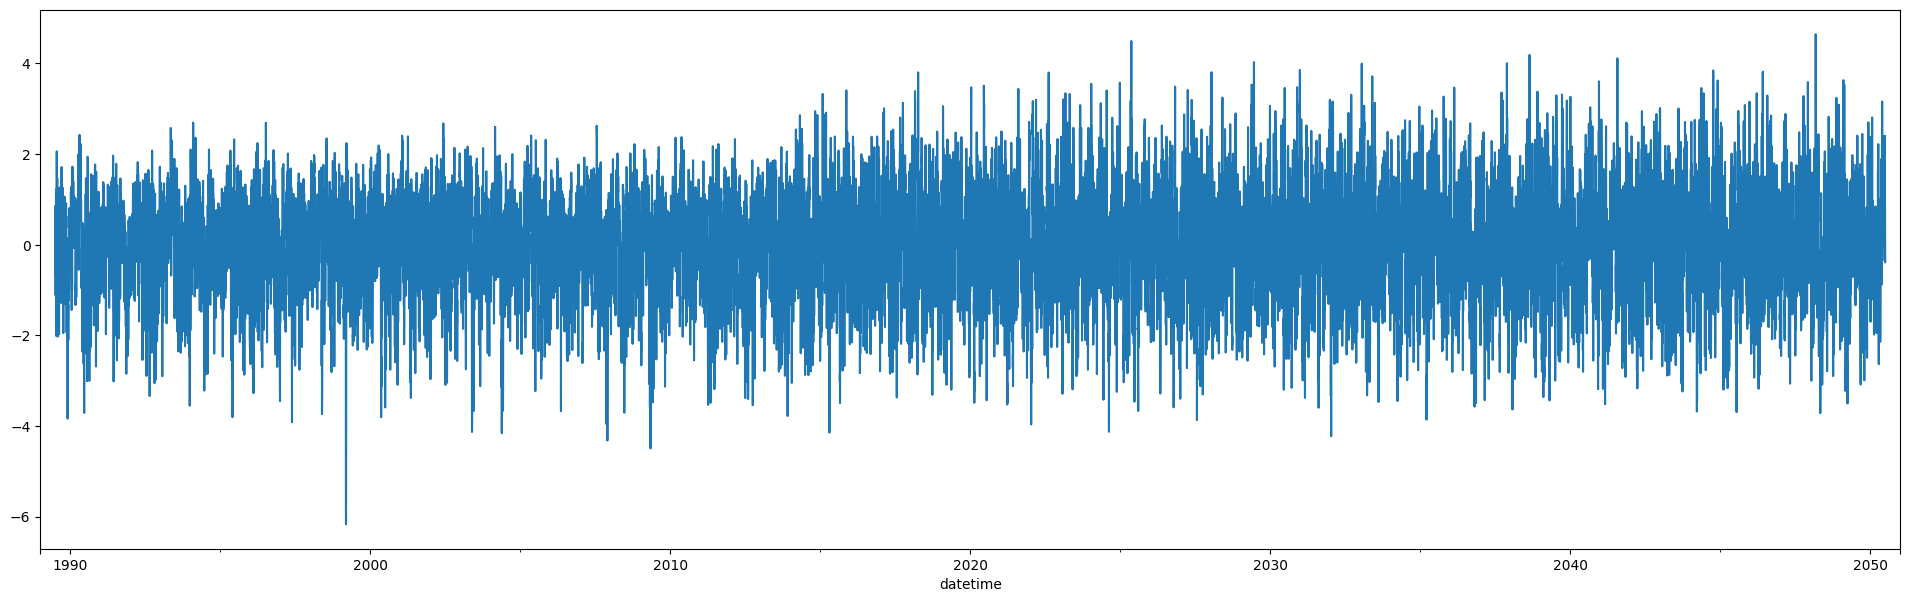

In [37]:
dec_result.resid.plot(figsize = (24, 7))

In [38]:
dec_result.trend.dropna()

datetime
1989-07-04    27.466575
1989-07-05    27.466027
1989-07-06    27.465479
1989-07-07    27.464932
1989-07-08    27.465205
                ...    
2050-06-28    27.847552
2050-06-29    27.842974
2050-06-30    27.838895
2050-07-01    27.836069
2050-07-02    27.832326
Name: trend, Length: 22279, dtype: float64

In [39]:
trend_examine = dec_result.trend.dropna()

In [40]:
sd = seasonal_decompose(trend_examine, model = "additive", period = 365)

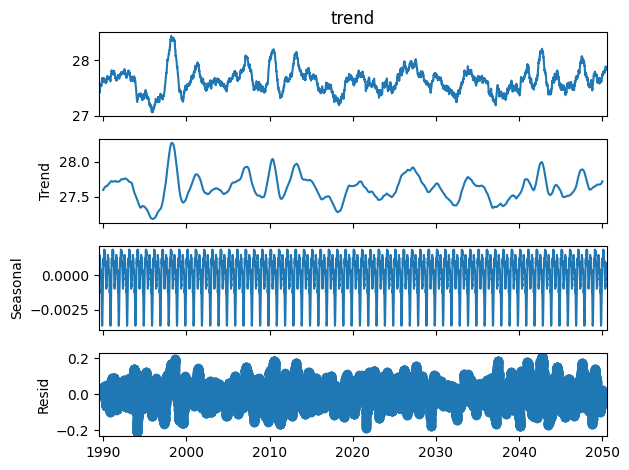

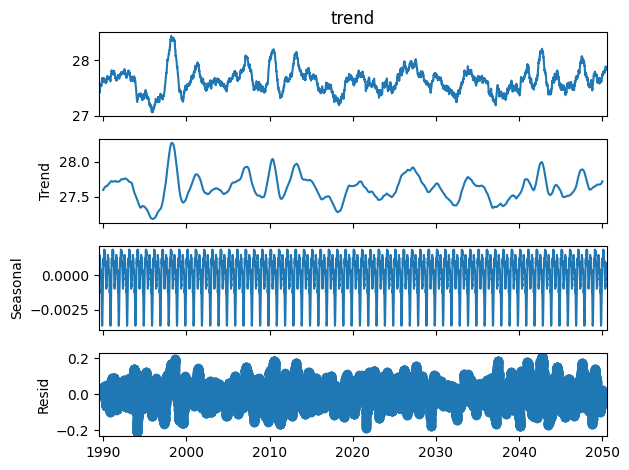

In [41]:
sd.plot()

In [42]:
trend_second_examine = sd.trend.dropna()

In [43]:
sd = seasonal_decompose(trend_second_examine, model = "additive")

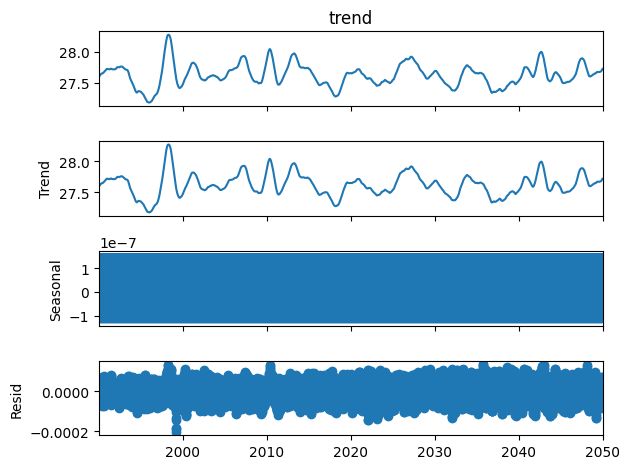

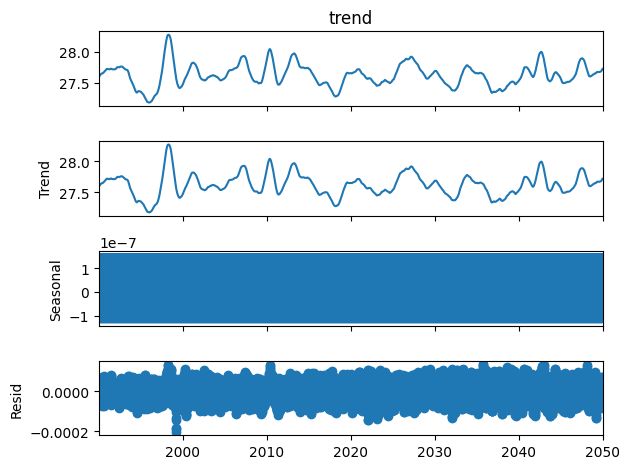

In [44]:
sd.plot()

In [45]:
constructed_df["MonthYear"] = pd.DatetimeIndex(constructed_df["datetime"]).year * 1000_00 + pd.DatetimeIndex(constructed_df["datetime"]).month
normalized_df["MonthYear"] = pd.DatetimeIndex(normalized_df["datetime"]).year * 1000_00 + pd.DatetimeIndex(normalized_df["datetime"]).month

In [46]:
cons_grpings = constructed_df.groupby(by = "MonthYear").mean(numeric_only = True)
norm_grpings = normalized_df.groupby(by = "MonthYear").mean(numeric_only = True)
cg = cons_grpings["TempMod"].to_numpy()
ng = norm_grpings["temp"].to_numpy()

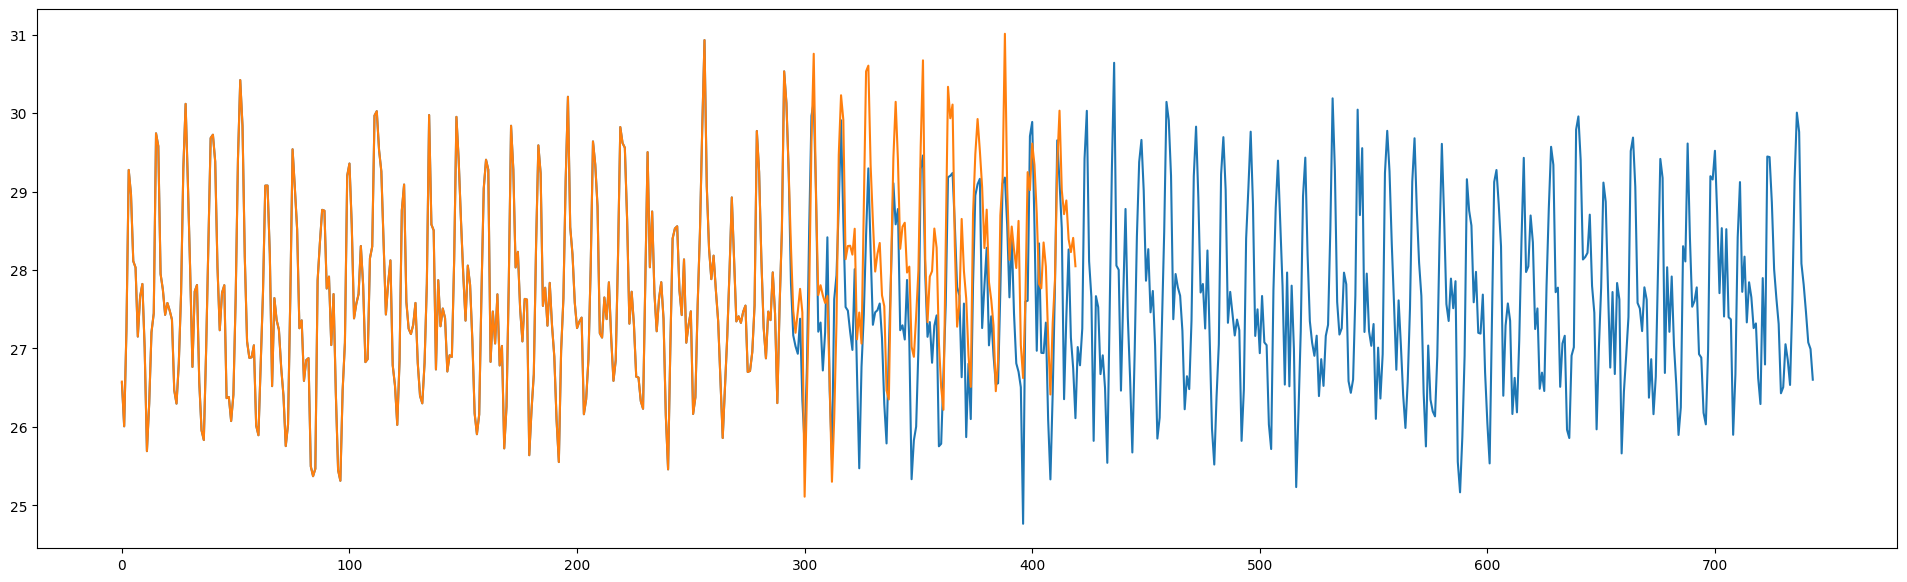

In [47]:
plt.figure(figsize = (24, 7))
plt.plot(cg)
plt.plot(ng)
plt.show()

# Yearly Decomposition Investigation

If there is an actual trend that can be seen on the yearly data

Additive Model = Value = Seasonality + Trend + Error
Multiplicative Model = Value = Seasonality * Trend * Error

In [48]:
yearly_means = df.groupby(by = "Year").mean(numeric_only = True)["temp"].values
sy = pd.to_datetime(df["datetime"][0])
ey = pd.to_datetime(df["datetime"][len(df["datetime"]) - 1]) + timedelta(days = 1)
yr = np.arange(sy, ey, dtype = "datetime64[Y]")

decomposition_mode = "additive"

yearly_df = pd.DataFrame({
    "means" : yearly_means
}, index = yr)


# Trend Across Varying Periods

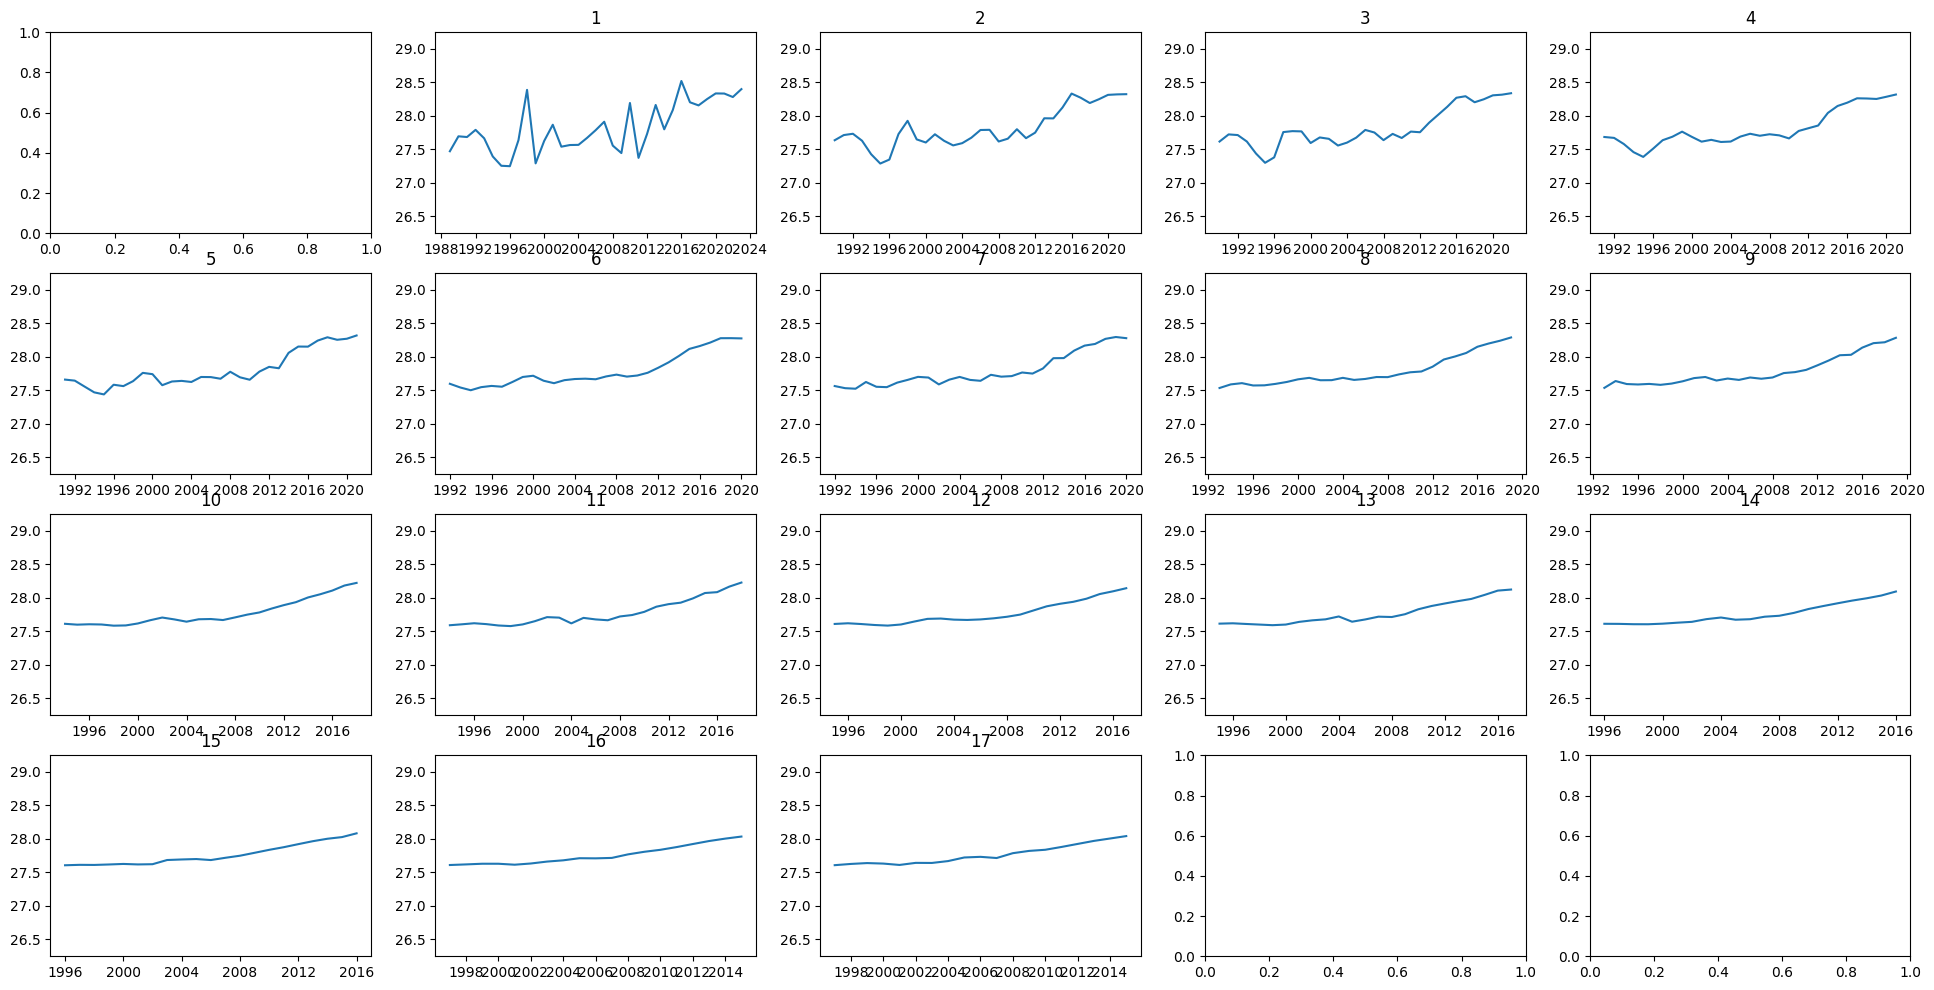

In [49]:
cols = 5
rows = yr.shape[0] // 2 // cols + 1
fig, ax = plt.subplots(rows, cols, figsize = (24, 12))

lowest_val = min(yearly_df["means"]) - 1
highest_val = min(yearly_df["means"]) + 2

for i in range(1, yr.shape[0] // 2 + 1):
    try:
        ysd = seasonal_decompose(yearly_df["means"], model = decomposition_mode, period = i)
        x = i % cols 
        y = i // cols 

        ax[y, x].plot(ysd.trend)
        ax[y, x].set_title(i)
        ax[y, x].set_ylim([lowest_val, highest_val])

    except Exception as E:
        print("Error at i:", i, "Error:", E)

# clear_output()
plt.show()


# Seasonality Across Varying Periods

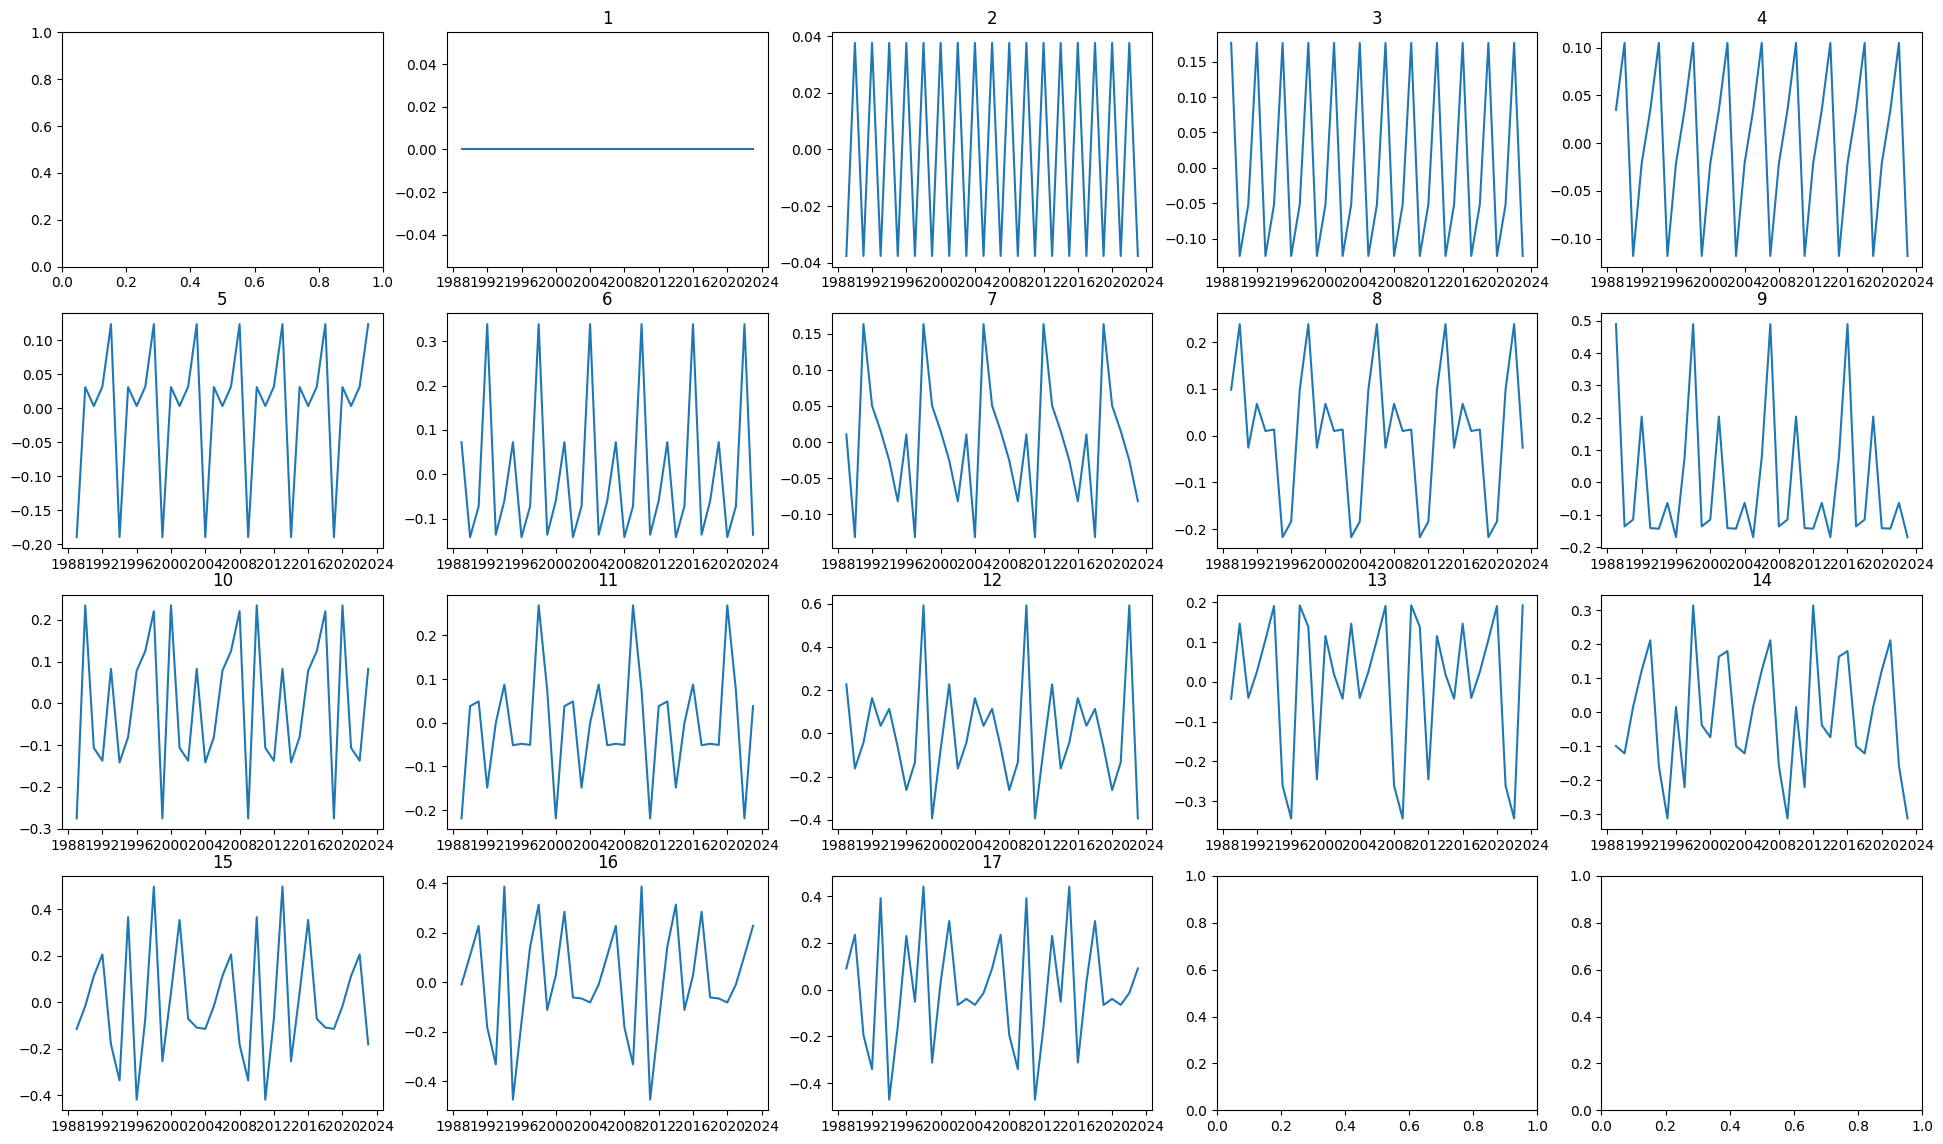

In [50]:
cols = 5
rows = yr.shape[0] // 2 // cols + 1
fig, ax = plt.subplots(rows, cols, figsize = (24, 14))

for i in range(1, yr.shape[0] // 2 + 1):
    try:
        ysd = seasonal_decompose(yearly_df["means"], model = decomposition_mode, period = i)
        x = i % cols 
        y = i // cols 

        ax[y, x].plot(ysd.seasonal)
        ax[y, x].set_title(i)
    except Exception as E:
        print("Error at i:", i, "Error:", E)

plt.show()

# Residue Across Varying Periods

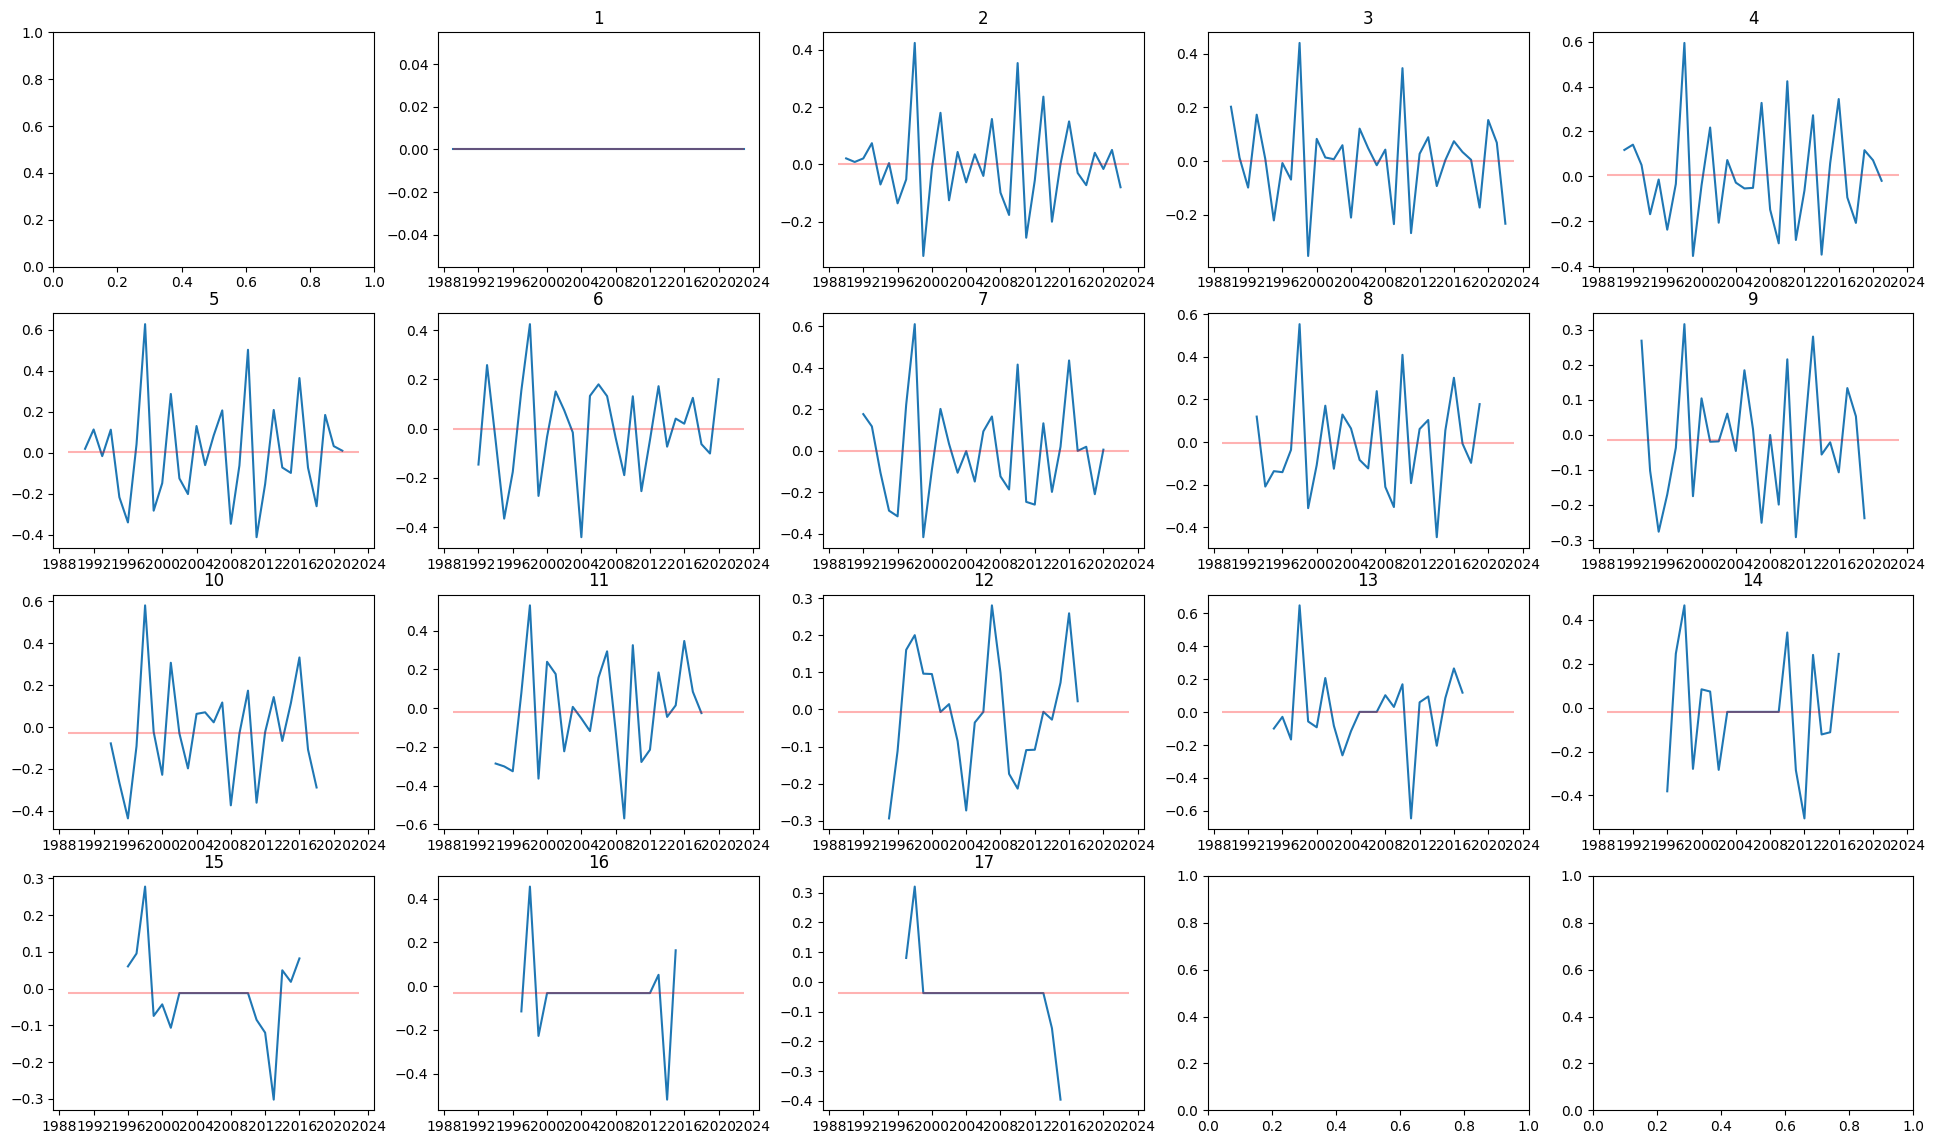

In [51]:
cols = 5
rows = yr.shape[0] // 2 // cols + 1
fig, ax = plt.subplots(rows, cols, figsize = (24, 14))

for i in range(1, yr.shape[0] // 2 + 1):
    try:
        ysd = seasonal_decompose(yearly_df["means"], model = decomposition_mode, period = i)
        x = i % cols 
        y = i // cols 

        ax[y, x].plot(ysd.resid)
        ax[y, x].hlines(ysd.resid.mean(), ysd.resid.index[0], ysd.resid.index[-1], color = "red", alpha = 0.3)
        ax[y, x].set_title(i)
    except Exception as E:
        print("Error at i:", i, "Error:", E)

plt.show()

# Periodicity = 7/8

From 